## A/B Test Results For E-Commerce Website


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

This will be a test to see if an e-commerce website should implement a new page or keep using the original version they currently have. There are a few different approaches in order to properly conduct this type of analysis and this will be an exercise of these different techniques. Here I will utilize the bootstrap sampling with replacement technique and the statsmodel api for its built-in and ability to deploy regression models.

<a id='probability'></a>
#### Part I - Probability

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
# Number of total users
df.shape

(294478, 5)

In [4]:
# Number of unique users
df.user_id.nunique()

290584

In [5]:
# Proportion of users converted
df.converted.mean()

0.11965919355605512

In [6]:
# Number of times the new page and treatment don't line up
df[((df['group']=='treatment') & (df['landing_page']!='new_page')) | ((df['group']!='treatment') & (df['landing_page']=='new_page'))].shape

(3893, 5)

In [7]:
# Checking for missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

>For the rows where **treatment** is not aligned with **new_page**, or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  We will have to create a new dataset where these occurances are removed.

In [8]:
df = df.drop(df[((df['group']=='treatment') & (df['landing_page']!='new_page')) | ((df['group']!='treatment') & (df['landing_page']=='new_page'))].index)

In [9]:
df2 = df.drop(df[((df['group']=='control') & (df['landing_page']!='old_page')) | ((df['group']!='control') & (df['landing_page']=='old_page'))].index)

In [10]:
# Checking if all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [11]:
df2.user_id.nunique()

290584

In [12]:
# Finding duplicated row
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:
# Removing duplicate
df2 = df2.drop_duplicates(['user_id'])
df2.shape

(290584, 5)

In [14]:
# Probability a user converting
df2.converted.mean()

0.11959708724499628

In [15]:
# Probability of a user from the control group converting 
df2[df2['group']=='control'].converted.mean()

0.1203863045004612

In [16]:
# Probability of a user in the treatment group converting
df2[df2['group']=='treatment'].converted.mean()

0.11880806551510564

In [17]:
# Probability a user received the new page
len(df2[df2['landing_page']=='new_page']) / len(df2)

0.5000619442226688

> The evidence shows that there is no significant difference between the two types of landing pages and their affect on whether a user will convert or not.

<a id='ab_test'></a>
### Part II - A/B Test

Because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the issue is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


For now, we will assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.

### Hypothesis

- __Null Hypothesis (H0)__ = The conversion rate of the new page is no better than the old ($p_{new}$ <= $p_{old}$)<br>
- __Alternative Hypothesis (H1)__ = New page is proven to be better ($p_{new}$ > $p_{old}$)

We will assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, we will assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Through the utilization of a sample size for each page equal to the ones in **ab_data.csv**, we will perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.

In [18]:
# Convert rate for Pnew under the null
p_new = df2.converted.mean()
print('P new is:', p_new)

P new is: 0.11959708724499628


In [19]:
# Convert rate for Pold under the null
p_old = df2.converted.mean()
print('P old is:', p_old)

P old is: 0.11959708724499628


In [20]:
# Calculating Nnew
n_new = len(df2[df2['group']=='treatment'].converted)
print('N new is:', n_new)

N new is: 145310


In [21]:
# Calculating Nold
n_old = len(df2[df2['group']=='control'].converted)
print('N new is:', n_old)

N new is: 145274


In [22]:
# Simulation of Nnew transactions with a convert rate of Pnew under the null
new_page_converted = np.random.binomial(n_new, p_new)

In [23]:
# Simulation of Nold transactions with a convert rate of Pold under the null
old_page_converted = np.random.binomial(n_old, p_old)

In [24]:
# Difference calulation
new_page_converted/n_new - old_page_converted/n_old

0.0004312886489204054

In [25]:
# Simulation of 10,000 Pnew - Pold values
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new, p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    diff = new_page_converted/n_new - old_page_converted/n_old
    p_diffs.append(diff)

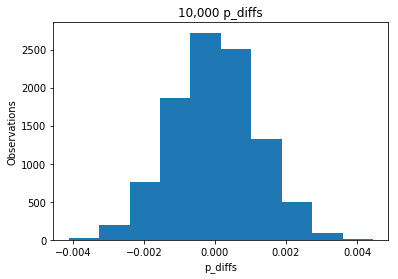

In [26]:
plt.hist(p_diffs);
plt.title('10,000 p_diffs')
plt.xlabel('p_diffs')
plt.ylabel('Observations');

In [27]:
# Proportion of the p_diffs that are greater than the actual diff observed in original data
act_diff = df2[df2['group'] == 'treatment']['converted'].mean() -  df2[df2['group'] == 'control']['converted'].mean()
act_diff

-0.0015782389853555567

In [28]:
p_diffs = np.array(p_diffs)
(act_diff < p_diffs).mean()

0.9079

**This is the calculation for the p-value. This value is the probability of observing our statistic (or one more extreme) if the null hypothesis is true. In this case, our findings have proven that the new page has no advantage in conversion rate. So we can as a result, we cannot reject our null hypothesis, as the old pages have shown to have a slightly stronger conversion rate.**

We will now use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.

In [29]:
import statsmodels.api as sm

convert_old = sum(df2.query("group == 'control'")['converted'])
convert_new = sum(df2.query("group == 'treatment'")['converted'])
n_old = len(df2.query("group == 'control'"))
n_new = len(df2.query("group == 'treatment'"))

In [30]:
# Using built-in to calculate z and p scores
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


In [31]:
from scipy.stats import norm
#Testing the significance of z-score
print(norm.cdf(z_score))

#Assumed at 95% confidence level, for single-sides test
print(norm.ppf(1-(0.05)))

0.9050583127590245
1.6448536269514722


**We cannot reject our null hypothesis since the z-score of 1.311 is less than the critical value of 1.645. So old pages are only slightly better than new ones and these findings agree with the previous ones found earlier.**

<a id='regression'></a>
### Part III - A regression approach

In this final part, we will see that the results acheived in the previous A/B test can also be acheived by performing regression. We will be conducting a logistic regression since each row is either a conversion or no conversion.

>The goal is to use **statsmodels** to fit the logistic regression model and see if there is a significant difference in conversion based on which page a customer receives.  However, I first need to create a column for the intercept, and create a dummy variable column for which page each user received.

In [32]:
df2['intercept'] = 1
df2[['control','treatment']] = pd.get_dummies(df2['group'])

In [33]:
# Instantiation and fitting of model

logit = sm.Logit(df2['converted'],df2[['intercept' ,'treatment']])
results = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [34]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 22 Sep 2018   Pseudo R-squ.:               8.077e-06
Time:                        16:36:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**The p-value here is .190. This differs from the one found in part II because here we have a two-sided test, before it was only one. **

>Should we consider other factors that might influence whether or not an individual converts? Yes, it is absolutely a good idea to consider other factors to include into the regression model. Variables such as user age, where they live, device used, can all be incredibly important factors to consider in a study like this. However, there are disadvantages to adding additional terms to the model as we can run into something like the Simpson's paradox where we may see a trend in several groups of data but it disappears or reverses when combined with other, or newly added groups.

>Now we will add another variable to the equation, which is the country a user lives. This will require reading in the **countries.csv** dataset and mergeing together the datasets.

In [35]:
df_countries = pd.read_csv('./countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [36]:
df_new = df_countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [37]:
# Breakdown of different countries
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [38]:
# Creating dummy variables
df_new['intercept'] = 1
df_new[['CA','US']] = pd.get_dummies(df_new['country'])[['CA','US']]

>Though we have looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there are significant effects on conversion.  We'll create the necessary additional columns, and fit the new model.

In [39]:
log_mod = sm.Logit(df_new['converted'], df_new[['CA', 'US']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.447174
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 22 Sep 2018   Pseudo R-squ.:                 -0.2214
Time:                        16:36:45   Log-Likelihood:            -1.2994e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CA            -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US            -1.9967      0.007   -292.314      0.000      -2.010      -1.983
==============================================================================
"""

In [40]:
np.exp(results.params)

CA    0.130350
US    0.135779
dtype: float64

In [41]:
df2.groupby('group').mean()['converted']

group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64

<a id='conclusions'></a>
## Conclusion

So there does not appear to be a significant difference between the old and new pages which further reinforces our failure to reject the null hypothesis and confidently keep the old page's format. It should be noted, these inferences our gathered from only the available data presented in this study and is therefore limited in scope that could perhaps be broadened with the inclusion of other elements.